In [7]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import gamma
import scipy
import scipy.special as sp
from scipy.integrate import quad
from scipy.optimize import minimize

# Simulation of GLE with stochastic resetting of the memory kernel

## Fitting the kernel with superposition of exponentials

In [98]:
# Parameters

N = 25
m = 1.0
kBT = 1.0
gamma_scale = 1
dt = 1e-3
Tmax = 100
T = Tmax
steps = int(Tmax/dt)

b = 0
r = 0
alpha = 0.4

tau_min = dt
tau_max = 10**7
tau_i = np.logspace(np.log10(tau_min), np.log10(tau_max), N)

t_fit = np.logspace(-3, np.log10(Tmax), 1000)

In [99]:
# Memory kernel without resetting

def gamma_t(t, alpha, b):
    if t == 0:
        return np.inf
    return np.exp(-b*t) * (t**(-alpha)/ gamma(1-alpha))

# Memory kernel with resetting

def gamma_r(t, alpha, r, b):
    if t == 0:
        return np.inf
    first_term = np.exp(-r * t) * gamma_t(t, alpha, b)
    integral_func = lambda t_prime: np.exp(-r * t_prime) * gamma_t(t_prime, alpha, b) * r
    second_term, _ = quad(integral_func, 0, t)
    return first_term + second_term

In [100]:
# Calculating the target kernel values over time

gamma_r_values = [gamma_r(t, alpha, r, b) for t in t_fit]

K_target = gamma_scale * np.array(gamma_r_values)

In [101]:
# Fitting procedure for the kernel

A = np.exp(-np.outer(t_fit, 1.0/tau_i))

def objective(c):
    return np.sum((A @ c - K_target)**2)

c_init = np.ones(N)

bounds = [(0, None) for _ in range(N)]  # enforcing only positive c_i >= 0

result = minimize(objective, c_init, bounds=bounds, method='L-BFGS-B')

c_i = result.x

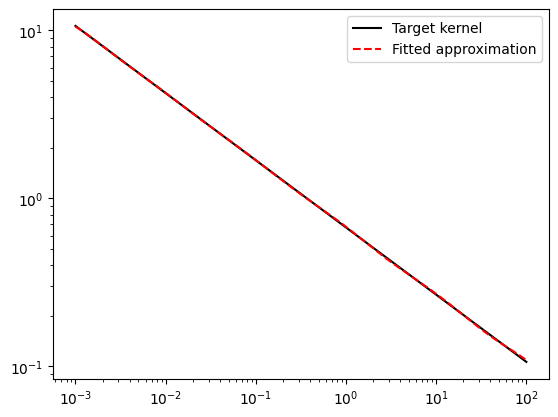

In [102]:
# Plotting the target kernel vs. its fitted approximation

K_approx = A @ c_i
plt.loglog(t_fit, K_target, 'k-', label='Target kernel')
plt.loglog(t_fit, K_approx, 'r--', label='Fitted approximation')
plt.legend()
plt.show()

## Markovian embedding

In [103]:
trajs = 1000
omega = 0
A_0 = 1
Omega = 1
gamma_scale = 1

X_Vec = np.zeros((steps, trajs))

x = np.zeros(trajs)
v = np.random.normal(0,1, size=trajs)
z = np.random.normal(0,np.sqrt(c_i), size=(trajs,N))

for step in range(steps):
    
    t = step*dt

    noise_prefactor = np.sqrt(c_i/tau_i)
    xi = np.sqrt(2)*np.random.normal(0,1,size=(trajs,N))
    xi *= np.sqrt(dt)

    dx = v
    dv = np.sum(z,axis=1) - omega**2*x + A_0 * np.cos(Omega * t)
    dz = (-(z / tau_i) - v[:, np.newaxis] * c_i)*dt + noise_prefactor*xi

    x += dx * dt
    v += dv * dt
    z += dz

    X_Vec[step,:] = x

    if step % (steps // 10) == 0:
         print(f"{(step/steps)*100:.0f}%")

0%
10%
20%
30%
40%
50%
60%
70%
80%
90%


## Estimating the frequency response, real and imaginary parts from the complex susceptibility

In [104]:
T = Tmax
n = steps

responses = []
real_parts = []
imag_parts = []

for i in range(trajs):

    x_t = X_Vec[:,i]

    X_f = scipy.fft.fft(x_t) / scipy.fft.fft(np.cos(Omega * np.linspace(0, T, steps))) # Fourier transform of x(t)

    frequencies = np.fft.fftfreq(steps, dt)

    drive_freq_index = np.argmin(np.abs(frequencies - Omega / (2 * np.pi)))
    
    response = np.abs(X_f[drive_freq_index])
    real_part = np.real(X_f[drive_freq_index])
    imag_part = np.imag(X_f[drive_freq_index])

    responses.append(response)
    real_parts.append(real_part)
    imag_parts.append(imag_part)

    if i % (trajs // 10) == 0:
         print(f"{(i/trajs)*100:.0f}%")

0%
10%
20%
30%
40%
50%
60%
70%
80%
90%


In [105]:
print(np.mean(response)) # absolute value of the complex susceptibility (response of the system to Omega)
print(np.mean(real_parts)) # real part of the complex susceptibilty
print(-np.mean(imag_parts)) # imaginary part of the complex susceptibilty

1.6274825493648
-0.4808126957589668
1.516756045631193


### Comparing analytical results with numerical simulations

In [106]:
# Analytical function for the complex susceptibility

def truncated_pl_kernel_susceptibility(Omega, alpha, r, omega, b):

    numerator = 1
    denominator = ((-1j * Omega + r) * (-1j * Omega + r + b)**(alpha - 1)) - Omega**2 + omega**2
    
    response = np.abs(numerator / denominator)  
    real_part = np.real(numerator / denominator)
    imag_part = np.imag(numerator / denominator)

    return response, real_part, imag_part

Results from numerical simulations

In [126]:
print(f"Results from numerical simulations for Omega = {Omega}:")

print(f"Response = {np.mean(responses):.3f}")
print(f"Real part = {np.mean(real_parts):.3f}")
print(f"Imaginary part = {-np.mean(imag_parts):.3f}")

Results from numerical simulations for Omega = 1:
Response = 1.611
Real part = -0.481
Imaginary part = 1.517


Results from analytical calculations

In [124]:
print(f"Results from analytical calculations for Omega = {Omega}:")

print(f"Response = {truncated_pl_kernel_susceptibility(Omega, alpha, r, omega, b)[0]:.3f}")
print(f"Real part = {truncated_pl_kernel_susceptibility(Omega, alpha, r, omega, b)[1]:.3f}")
print(f"Imaginary part = {truncated_pl_kernel_susceptibility(Omega, alpha, r, omega, b)[2]:.3f}")

Results from anaylytical calculations for Omega = 1:
Response = 1.618
Real part = -0.500
Imaginary part = 1.539
